<a href="https://colab.research.google.com/github/yashfx/Internship-Fx-data-labs/blob/Multiclass-classification/Multiclass_classification_on_pets_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
(train_raw, val_raw, test_raw), ds_info = tfds.load(name='oxford_iiit_pet',
                                                    split=['train[:90%]',
                                                          'train[90%:]',
                                                          'test'],
                                                    shuffle_files=True,
                                                    as_supervised=True, # Returns (image, label)
                                                    with_info=True # To retrieve dataset info and label names
                                                    )

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.OTYK8U_3.2.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.OTYK8U_3.2.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [ ]:
num_classes = ds_info.features['label'].num_classes
print('Number of classes:', num_classes)

Number of classes: 37


In [ ]:
num_train_examples = tf.data.experimental.cardinality(train_raw).numpy()
num_val_examples = tf.data.experimental.cardinality(val_raw).numpy()
num_test_examples = tf.data.experimental.cardinality(test_raw).numpy()

print('Number of training samples:', num_train_examples)
print('Number of validation samples:', num_val_examples)
print('Number of test samples:', num_test_examples)

Number of training samples: 3312
Number of validation samples: 368
Number of test samples: 3669


In [ ]:
get_label_name = ds_info.features['label'].int2str

In [ ]:
def view_single_image(ds):
    image, label = next(iter(ds))
    print('Image shape: ', image.shape)
    plt.imshow(image)
    _ = plt.title(get_label_name(label))

Image shape:  (333, 500, 3)


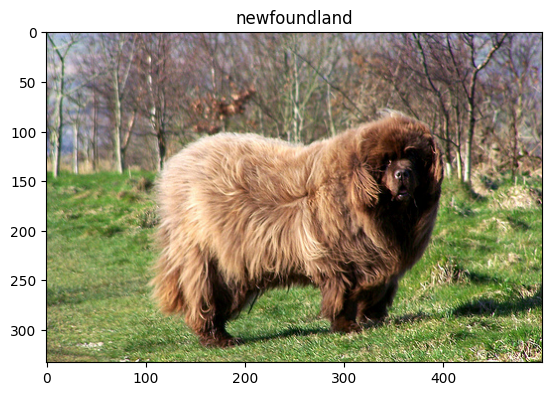

In [ ]:
view_single_image(train_raw)

In [ ]:
IMG_SIZE = 224

train_ds = train_raw.map(lambda x, y: (tf.image.resize(x, (IMG_SIZE, IMG_SIZE)), y))
val_ds = val_raw.map(lambda x, y: (tf.image.resize(x, (IMG_SIZE, IMG_SIZE)), y))
test_ds = test_raw.map(lambda x, y: (tf.image.resize(x, (IMG_SIZE, IMG_SIZE)), y))

In [ ]:
def one_hot_encode(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

In [ ]:
train_ds = train_ds.map(one_hot_encode)
val_ds = val_ds.map(one_hot_encode)
test_ds = test_ds.map(one_hot_encode)

In [ ]:
data_augmentation = keras.Sequential(
    [layers.RandomFlip('horizontal'),
    #  layers.RandomRotation(factor=(-0.025, 0.025)),
    #  layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    #  layers.RandomContrast(factor=0.1),
     ])

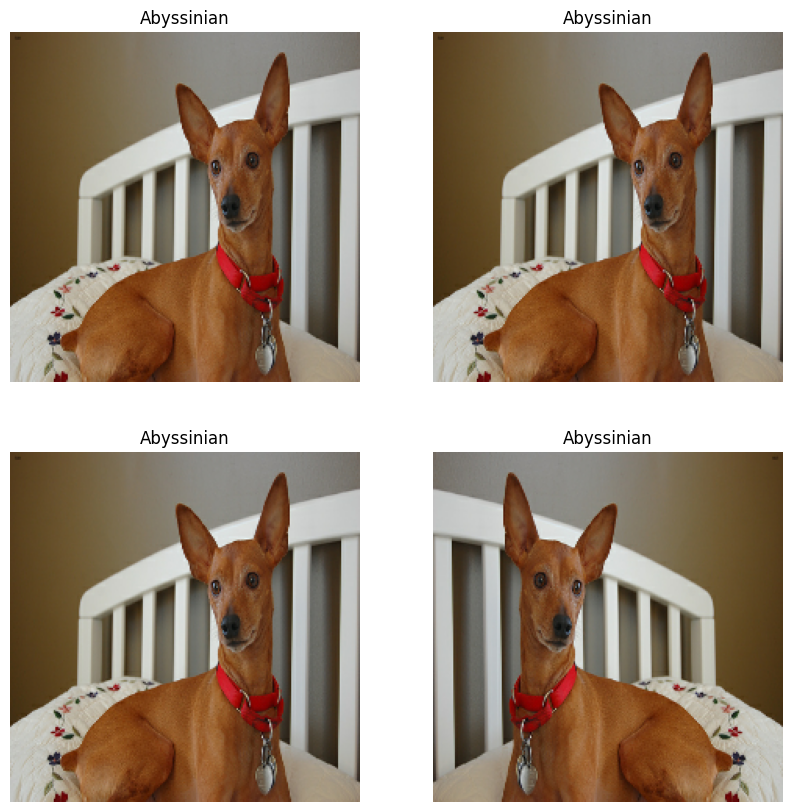

In [ ]:
for image, label in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(4):
        ax = plt.subplot(2, 2, i+1)
        aug_img = data_augmentation(tf.expand_dims(image, axis=0))
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title(get_label_name(int(label[0])))
        plt.axis("off")

In [ ]:
BATCH_SIZE = 32


In [ ]:
train_ds = train_ds.batch(batch_size=BATCH_SIZE,
                          drop_remainder=True).prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.batch(batch_size=BATCH_SIZE,
                      drop_remainder=True).prefetch(tf.data.AUTOTUNE)

test_ds = test_ds.batch(batch_size=BATCH_SIZE,
                        drop_remainder=True).prefetch(tf.data.AUTOTUNE)

In [ ]:
base_model = keras.applications.ResNet50V2(
                            include_top=False, # Exclude ImageNet classifier at the top.
                            weights="imagenet",
                            input_shape=(IMG_SIZE, IMG_SIZE, 3)
                            )

94668760/94668760 [==============================] - 1s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = keras.applications.resnet_v2.preprocess_input(x)
x = base_model(x, training=False)

In [ ]:
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)  # Regularize with dropout

outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

model = keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_3 (TFOpLam  (None, 224, 224, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_3 (TFOpLa  (None, 224, 224, 3)       0         
 mbda)                                                           
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0   

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=[keras.metrics.CategoricalAccuracy()]
             )

In [ ]:
EPOCHS = 25

history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, verbose=1
                    )

Epoch 1/25
103/103 [==============================] - 23s 133ms/step - loss: 1.2074 - categorical_accuracy: 0.6650 - val_loss: 0.6224 - val_categorical_accuracy: 0.8125
Epoch 2/25
103/103 [==============================] - 13s 124ms/step - loss: 0.2896 - categorical_accuracy: 0.9111 - val_loss: 0.4828 - val_categorical_accuracy: 0.8409
Epoch 3/25
103/103 [==============================] - 13s 125ms/step - loss: 0.1668 - categorical_accuracy: 0.9512 - val_loss: 0.4619 - val_categorical_accuracy: 0.8608
Epoch 4/25
103/103 [==============================] - 15s 147ms/step - loss: 0.1068 - categorical_accuracy: 0.9694 - val_loss: 0.4684 - val_categorical_accuracy: 0.8636
Epoch 5/25
103/103 [==============================] - 13s 126ms/step - loss: 0.0763 - categorical_accuracy: 0.9818 - val_loss: 0.4668 - val_categorical_accuracy: 0.8551
Epoch 6/25
103/103 [==============================] - 13s 125ms/step - loss: 0.0520 - categorical_accuracy: 0.9903 - val_loss: 0.4803 - val_categorical_acc

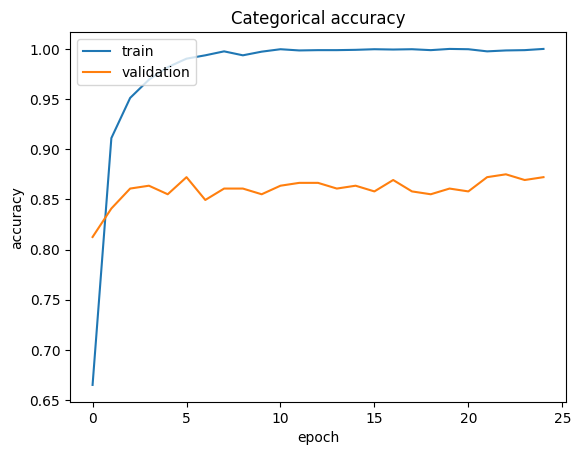

In [ ]:
def plot_hist(hist):
    plt.plot(hist.history['categorical_accuracy'])
    plt.plot(hist.history['val_categorical_accuracy'])
    plt.title('Categorical accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

plot_hist(history)

In [ ]:
preds = model.predict(test_ds)

114/114 [==============================] - 16s 135ms/step


In [ ]:
result = model.evaluate(test_ds)

114/114 [==============================] - 13s 113ms/step - loss: 0.5690 - categorical_accuracy: 0.8649
